## 1. Import libraries

In [178]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics


## 1.1. Helper Functions

In [27]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [39]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 2. Loading Data

In [206]:
df_raw = pd.read_csv( '../data/insurance.csv' )

In [207]:
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


---
# 3. EDA (  Exploration Data Analysis )
---

## 3.1. Descriptive Statistics

In [31]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


## 3.2. Univariate Analysis

## 3.2.1. Response Variable

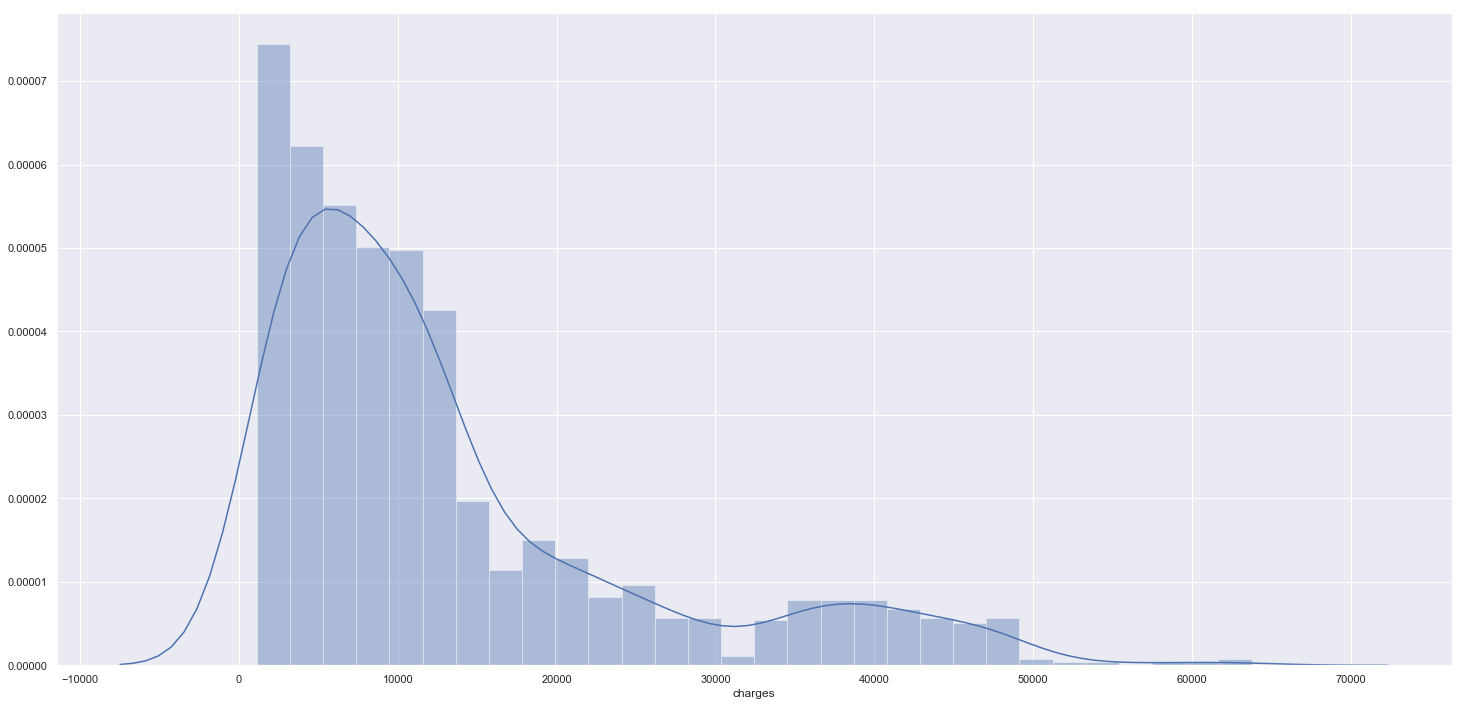

In [81]:
sns.distplot( df_raw['charges'] );

## 3.2.1. Predictors

### AGE

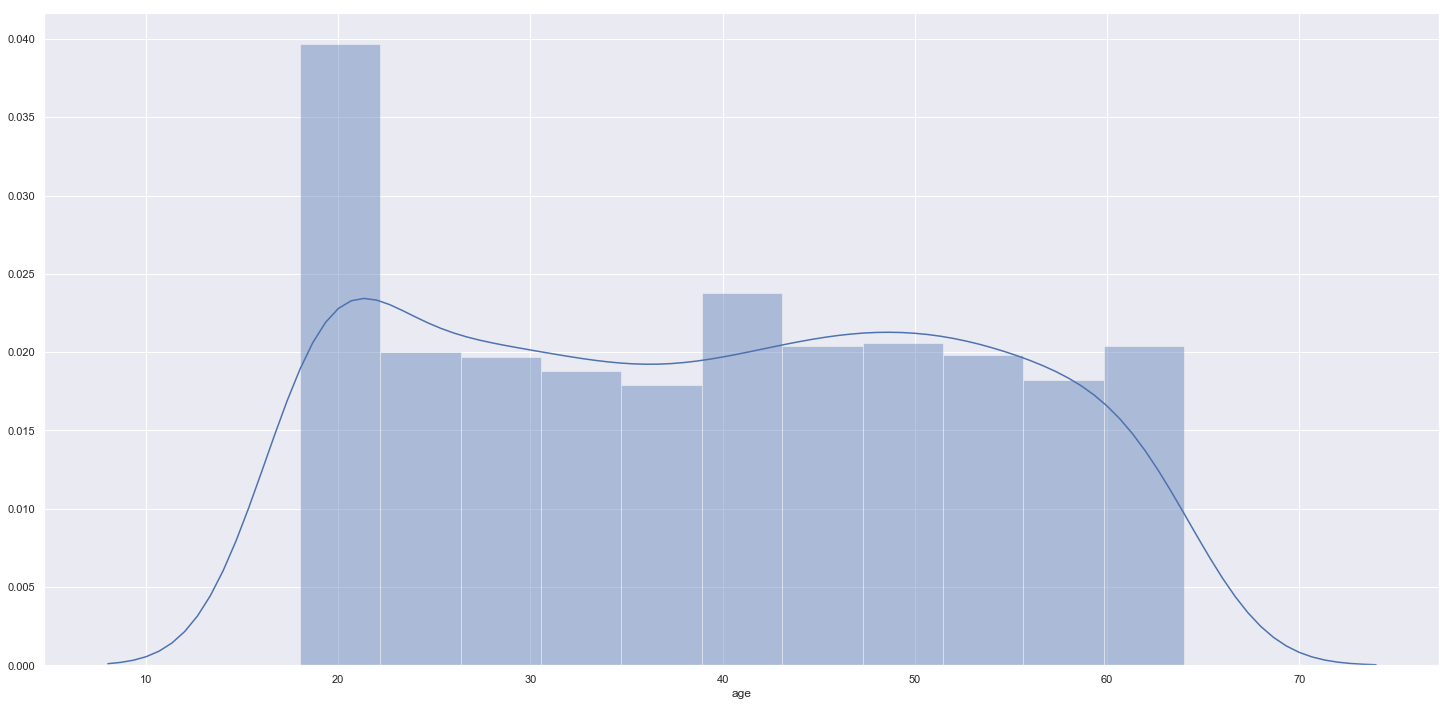

In [79]:
age = sns.distplot( df_raw['age'] )

### BMI

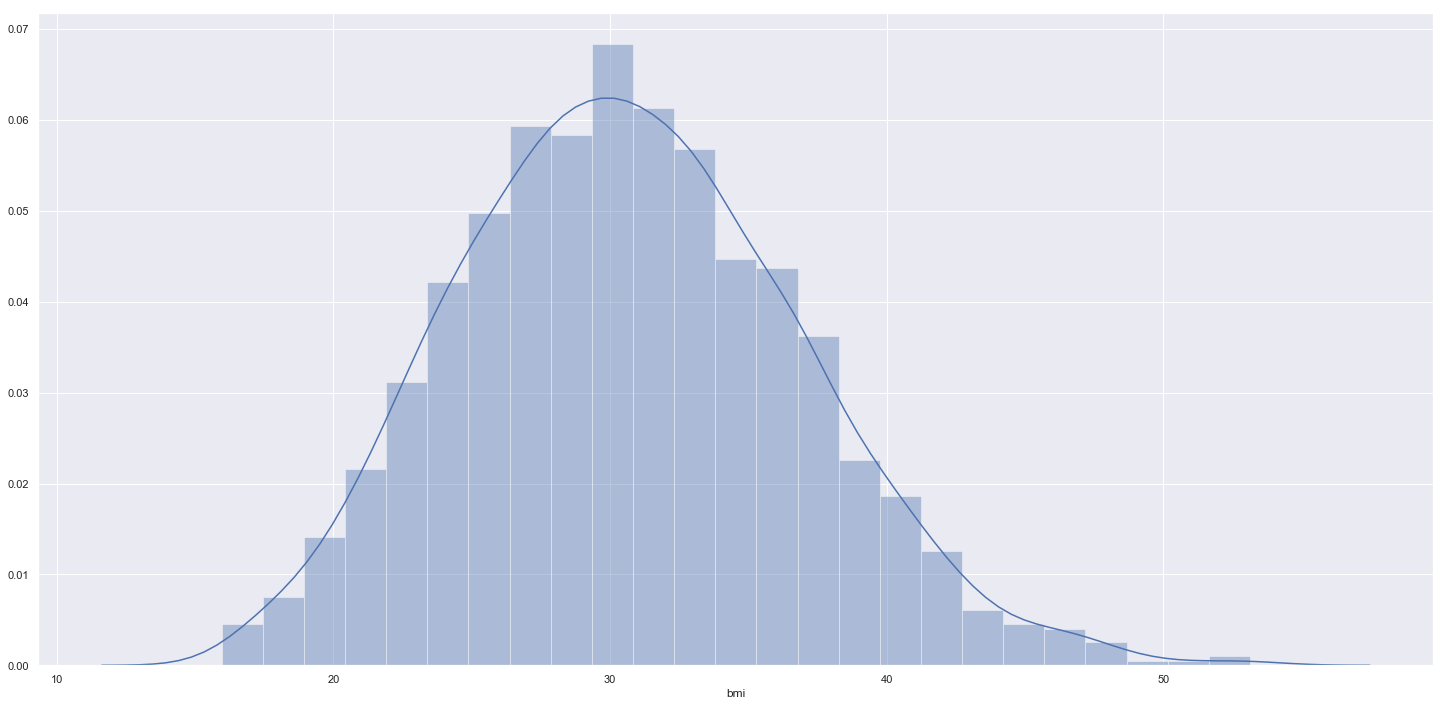

In [80]:
sns.distplot( df_raw['bmi'] )

### CHILDREN

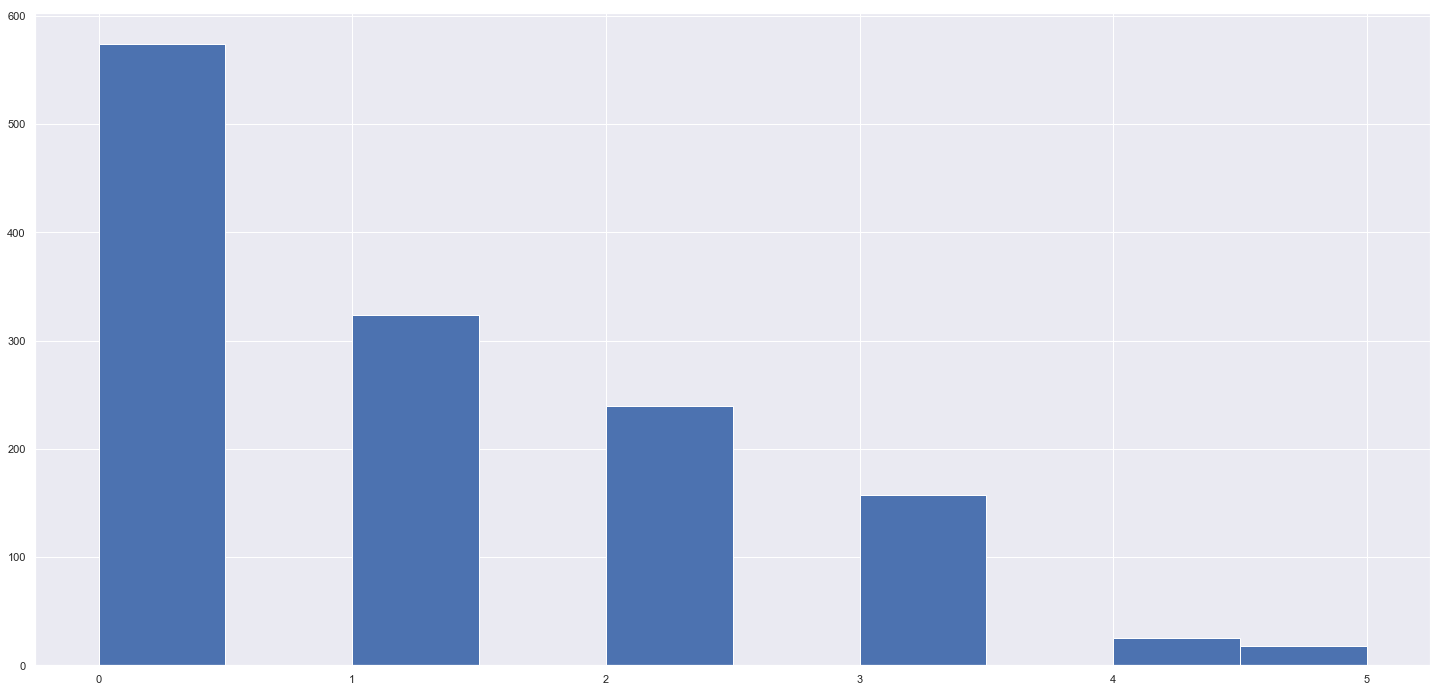

In [87]:
plt.hist( df_raw['children'] );

## 3.3. Bivariate Analysis

### 3.3.1. Numerical Predictors

In [73]:
num_features = df_raw.select_dtypes( include=[np.number] )
num_features.dtypes

# Correlation
corr = num_features.corr()
print( corr['charges'].sort_values( ascending=False ) )

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


### Age x Charges 

In [71]:
a = df_raw[['age', 'charges']].groupby( 'age' ).sum().reset_index()

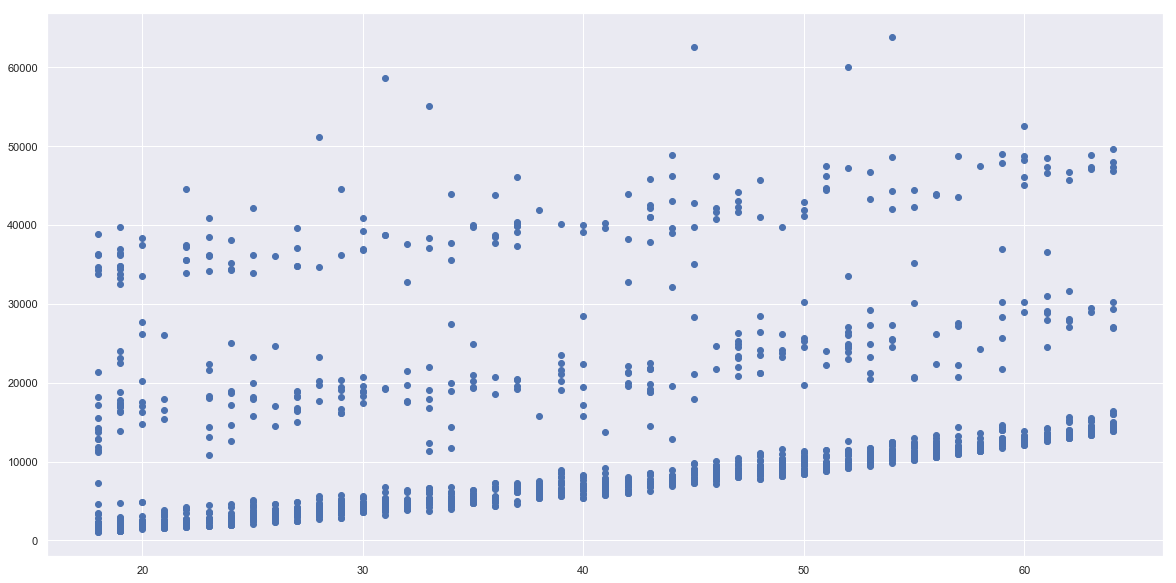

In [100]:
plt.figure( figsize=(20, 10) )
plt.scatter( df_raw['age'], df_raw['charges'] )

### BMI x Charges 

In [97]:
#a = df_raw[['bmi', 'charges']].groupby( 'bmi' ).sum().reset_index()

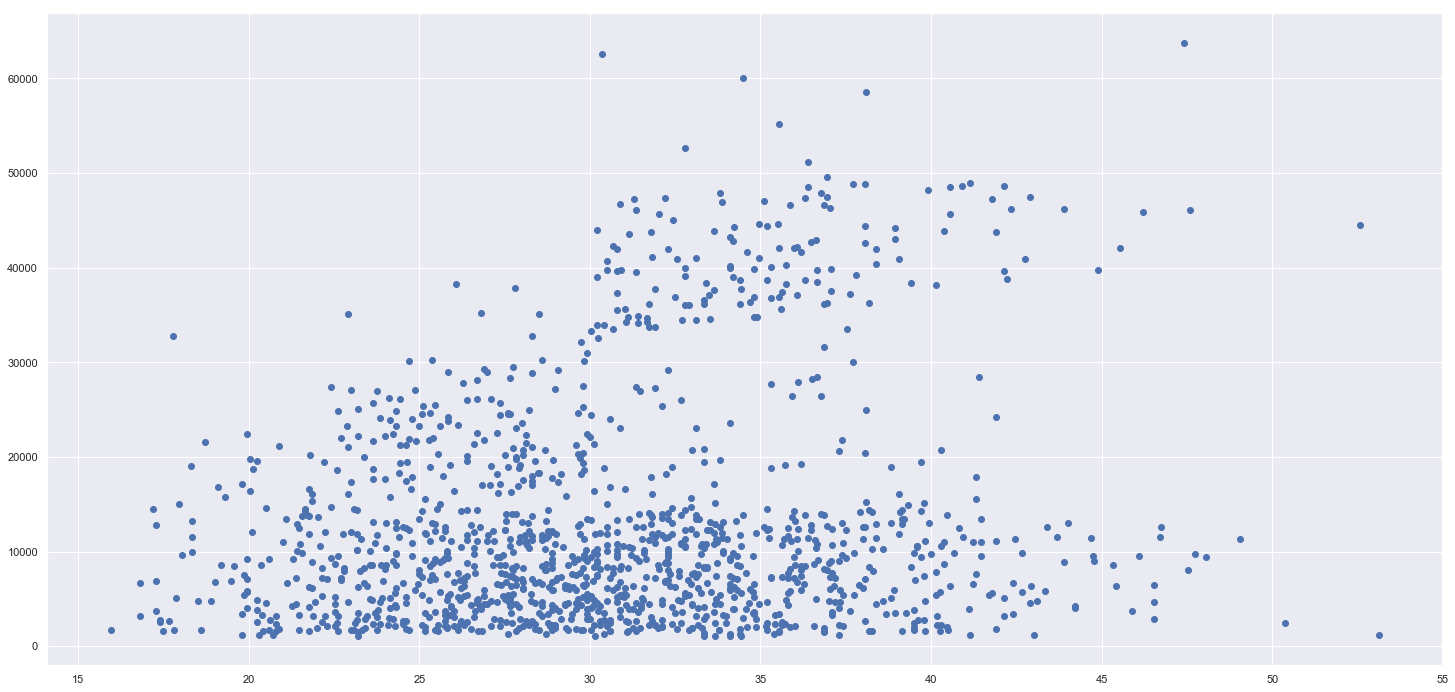

In [99]:
plt.scatter( df_raw['bmi'], df_raw['charges'] );

### Children x Charges 

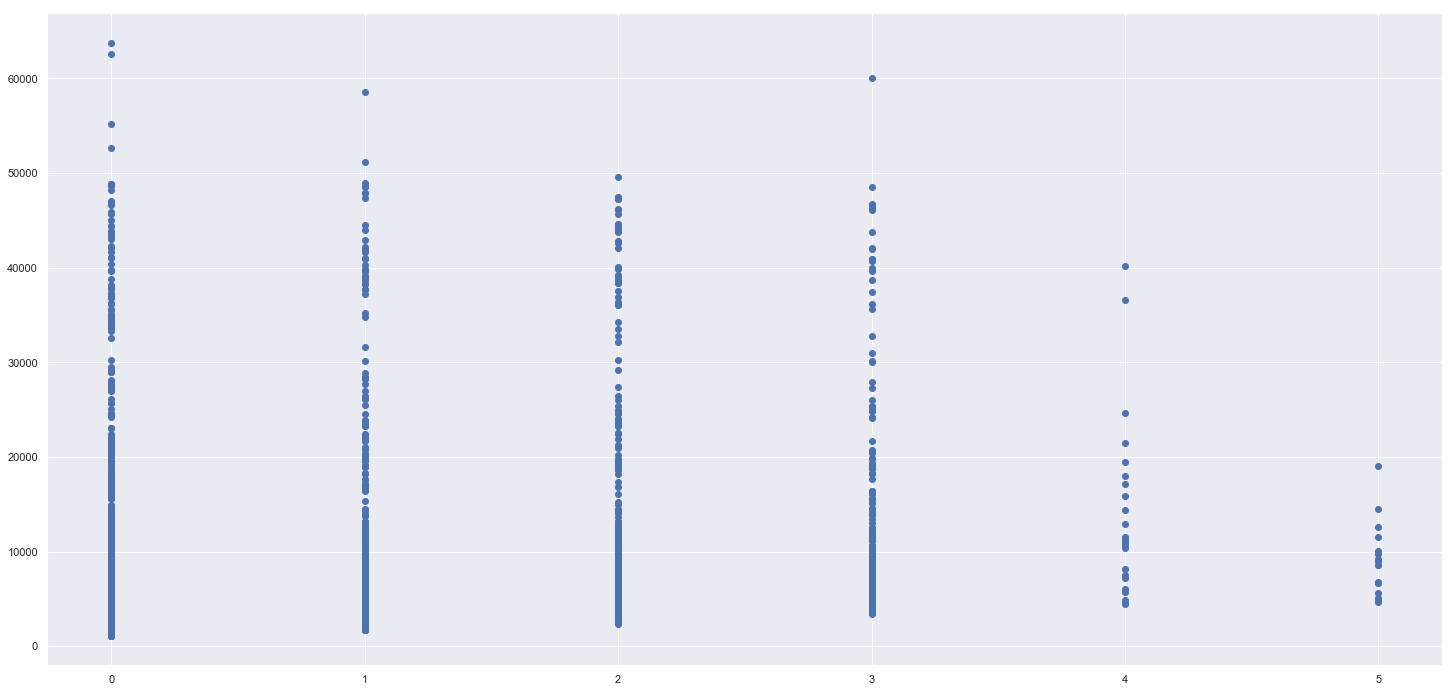

In [103]:
a = df_raw[['children', 'charges']].groupby( 'children' ).sum().reset_index()
plt.scatter( df_raw['children'], df_raw['charges'] );

### 3.3.2. Categorical Predictors

In [105]:
df_raw.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [106]:
cat_features = df_raw.select_dtypes( exclude=[np.number] )
cat_features.dtypes


sex       object
smoker    object
region    object
dtype: object

### Charges X Sex

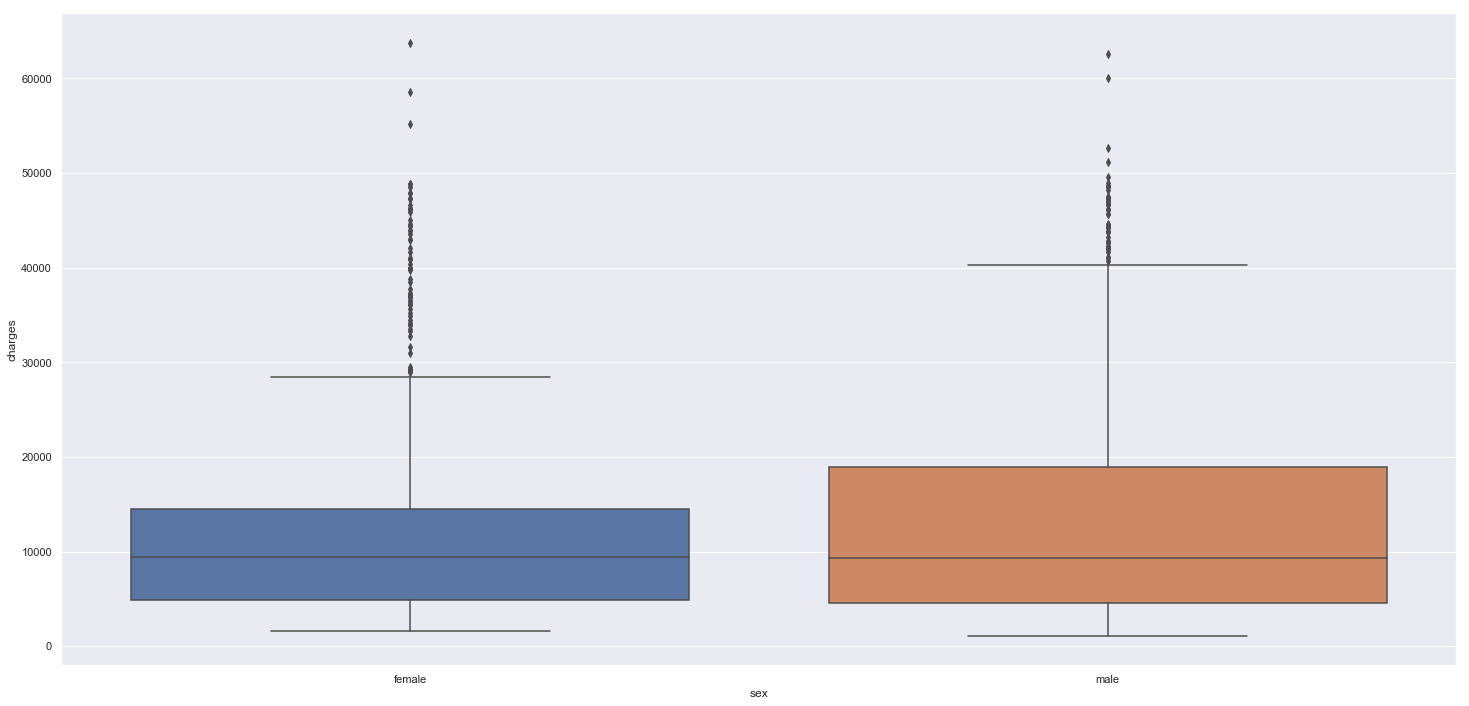

In [108]:
sns.boxplot( df_raw['sex'], df_raw['charges'] );

### Charges X Smoker

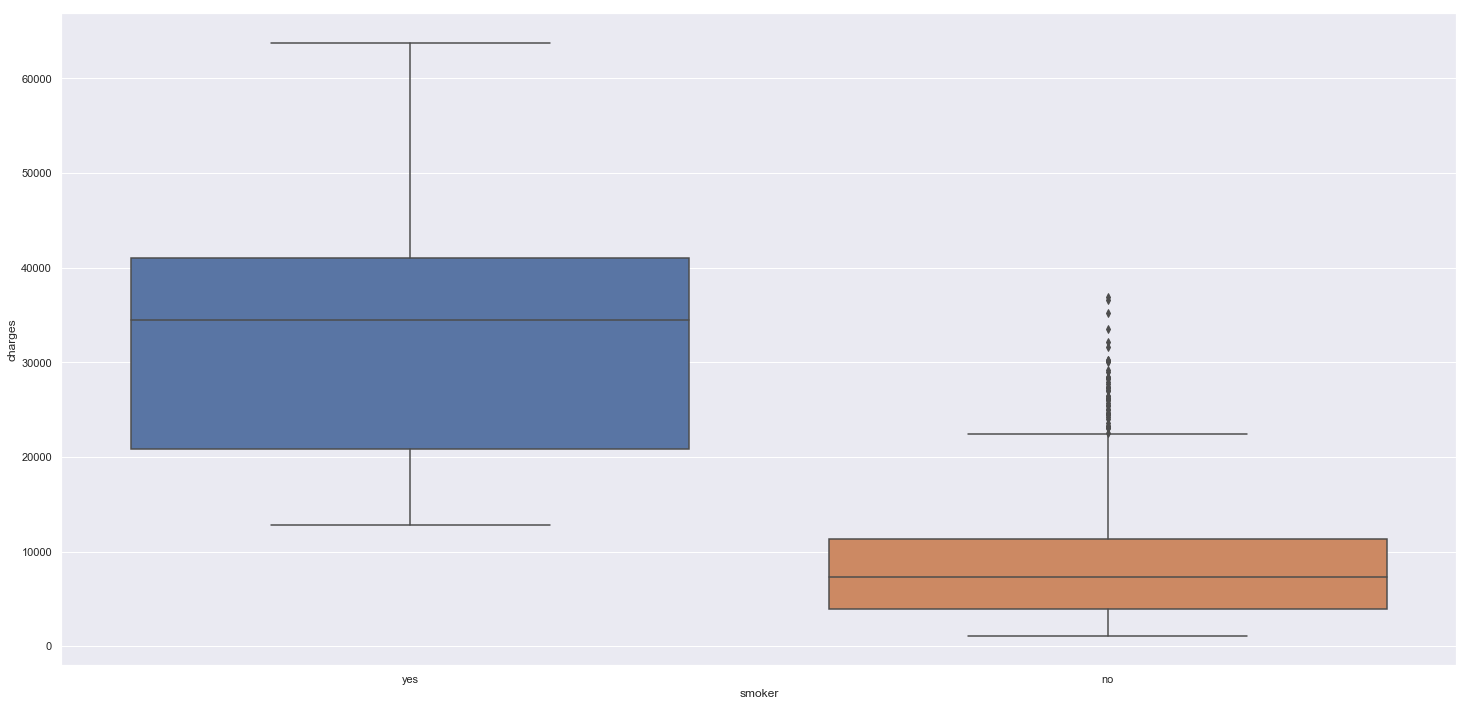

In [110]:
sns.boxplot( df_raw['smoker'], df_raw['charges'] );

### Charges X Region

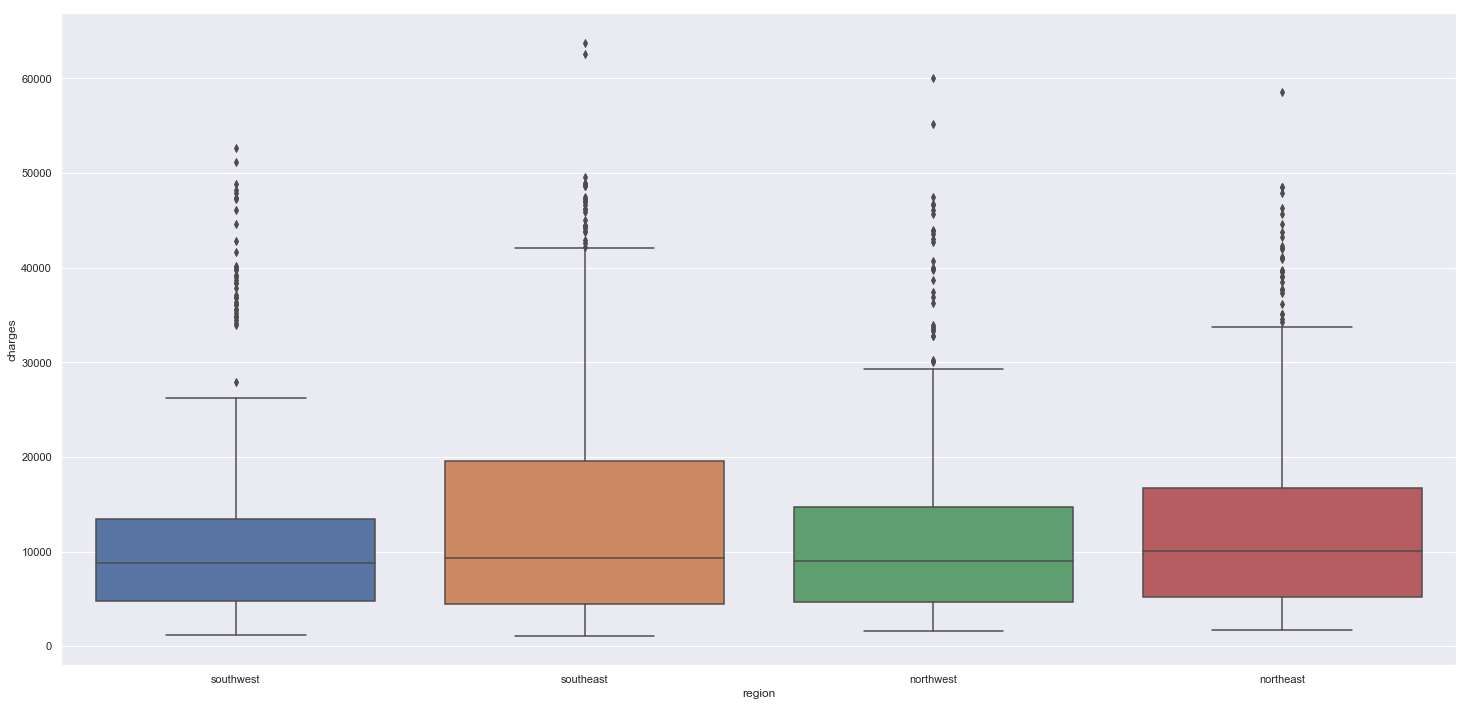

In [119]:
sns.boxplot( df_raw['region'], df_raw['charges'] );

## 3.4. Multivariate Analysis

---
# 4. Data Preprocessing  
---

## 4.1. Transformations 

In [477]:
data = df_raw

In [478]:
# Encode the column: Sex
data['sex'] = data['sex'].apply( lambda x: 1 if x == 'male' else 0 )
data = data.rename( columns={'sex': 'male'} )

# Encode the column: Smoker
data['smoker'] = data['smoker'].apply( lambda x: 1 if x == 'yes' else 0 )

# Dummy Encode the columns: Region
d = pd.get_dummies( data['region'] )
data = pd.concat( [data, d], axis=1 )

In [479]:
data.head()

,age,male,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0,1
1,18,0,33.770,1,0,southeast,1725.55230,0,0,1,0
2,28,0,33.000,3,0,southeast,4449.46200,0,0,1,0
3,33,0,22.705,0,0,northwest,21984.47061,0,1,0,0
4,32,0,28.880,0,0,northwest,3866.85520,0,1,0,0


## 4.2. Standardizing and Rescaling 

## 4.3. Binarization and Normalized

---
# 5. Feature Engineering  
---

## 5.1. Create Features

## 5.2. Feature Selection

### 5.2.1. Univariate Selection

### 5.2.2. Recursive Feature Elimination

### 5.2.3. Principal Component Analysis

## 5.3. Split Data into Train and Test Sets

In [480]:
X = data.drop( 'charges', axis=1 )
y = data['charges']

In [481]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )

---
# 6. Modelling
---

In [482]:
X_train.head()

,age,male,bmi,children,smoker,region,northeast,northwest,southeast,southwest
17,23,0,23.845,0,0,northeast,1,0,0,0
294,25,0,26.800,3,0,southwest,0,0,0,1
119,37,0,23.370,2,0,northwest,0,1,0,0
151,48,0,29.700,0,0,southeast,0,0,1,0
572,30,0,43.120,2,0,southeast,0,0,1,0


## 6.2. Linear Regression

In [ ]:
# Dataset
cols = ['age', 'male', 'bmi', 'children', 'smoker', 'northeast', 'northwest', 'southeast', 'southwest']
## Train
X_train = X_train[ cols ]
X_train = sm.add_constant( X_train )

## Test
X_test = X_test[cols]
X_test = sm.add_constant( X_test )

# sklearn
#lm = linear_model.LinearRegression()
#model = lm.fit( X_train, y_train ) 

# OLS
lm = sm.OLS( y_train, X_train ).fit()
print( lm.summary() )

## 6.3. Hierarchical Linear Model

In [483]:
X_train.head()

,age,male,bmi,children,smoker,region,northeast,northwest,southeast,southwest
17,23,0,23.845,0,0,northeast,1,0,0,0
294,25,0,26.800,3,0,southwest,0,0,0,1
119,37,0,23.370,2,0,northwest,0,1,0,0
151,48,0,29.700,0,0,southeast,0,0,1,0
572,30,0,43.120,2,0,southeast,0,0,1,0


In [487]:
# training data
#cols = ['age', 'male', 'bmi', 'children', 'smoker', 'region', 'charges']
cols = ['age', 'bmi', 'children', 'smoker', 'region', 'charges']
X_train = pd.concat( [X_train, y_train], axis=1 )
X_train = X_train[ cols ]

# Modelling
formula = 'charges ~ age + bmi + smoker + region' 

hier = sm.MixedLM.from_formula( formula, data=X_train, groups=X_train['region'] ).fit()

In [488]:
hier.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                    MixedLM         Dependent Variable:         charges      
No. Observations:         1070            Method:                     REML         
No. Groups:               4               Scale:                      37731265.9673
Min. group size:          256             Likelihood:                 -10805.9990  
Max. group size:          298             Converged:                  Yes          
Mean group size:          267.5                                                    
-----------------------------------------------------------------------------------
                       Coef.         Std.Err.       z    P>|z|   [0.025     0.975] 
-----------------------------------------------------------------------------------
Intercept             -11562.818         6240.304 -1.853 0.064 -23793.589   667.953
region[T.northwest]     -251.614         8703.804 -0.029 0.977 -17310.757 16807.529
region[T.southeast]     -942.782         8703.870 -0.108 0.914 -18002.054 16116.491
region[T.southwest]     -886.271         8704.035 -0.102 0.919 -17945.865 16173.324
age                      261.483           13.501 19.368 0.000    235.022   287.944
bmi                      334.174           32.434 10.303 0.000    270.603   397.744
smoker                 23510.353          468.002 50.236 0.000  22593.085 24427.620
Group Var           37731265.967 130355865164.047                                  
===================================================================================

"""

## 6.1. Training

### 6.1.1. K-Fold Cross-Validation

### 6.1.2. Leave One Out Cross-Validation

## 6.2. Test

In [489]:
# Liner Regression
#pred_lm = lm.predict( X_test )

# Hierarquical Regression
pred_hier = hier.predict( X_test )

---
# 7. Evaluation
---

## 7.1. Performance

In [490]:
mse = metrics.mean_squared_error( pred_hier, y_test )
rmse = np.sqrt( mse )

mae = metrics.mean_absolute_error( pred_hier, y_test )

print( 'MAE: {}'.format( mae ) )
print( 'RMSE: {}'.format( rmse ) )

MAE: 4102.321605049945
RMSE: 5861.005795784598


## 7.2. Residual Analysis

In [491]:
df = X_test
df['charges'] = y_test
df['prediction'] = pred_hier

df['residual'] = df['charges'] - df['prediction']


/Users/meigarom/repos/Predictive-Analytics/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/meigarom/repos/Predictive-Analytics/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/meigarom/repos/Predictive-Analytics/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Text(0, 0.5, 'Residual')

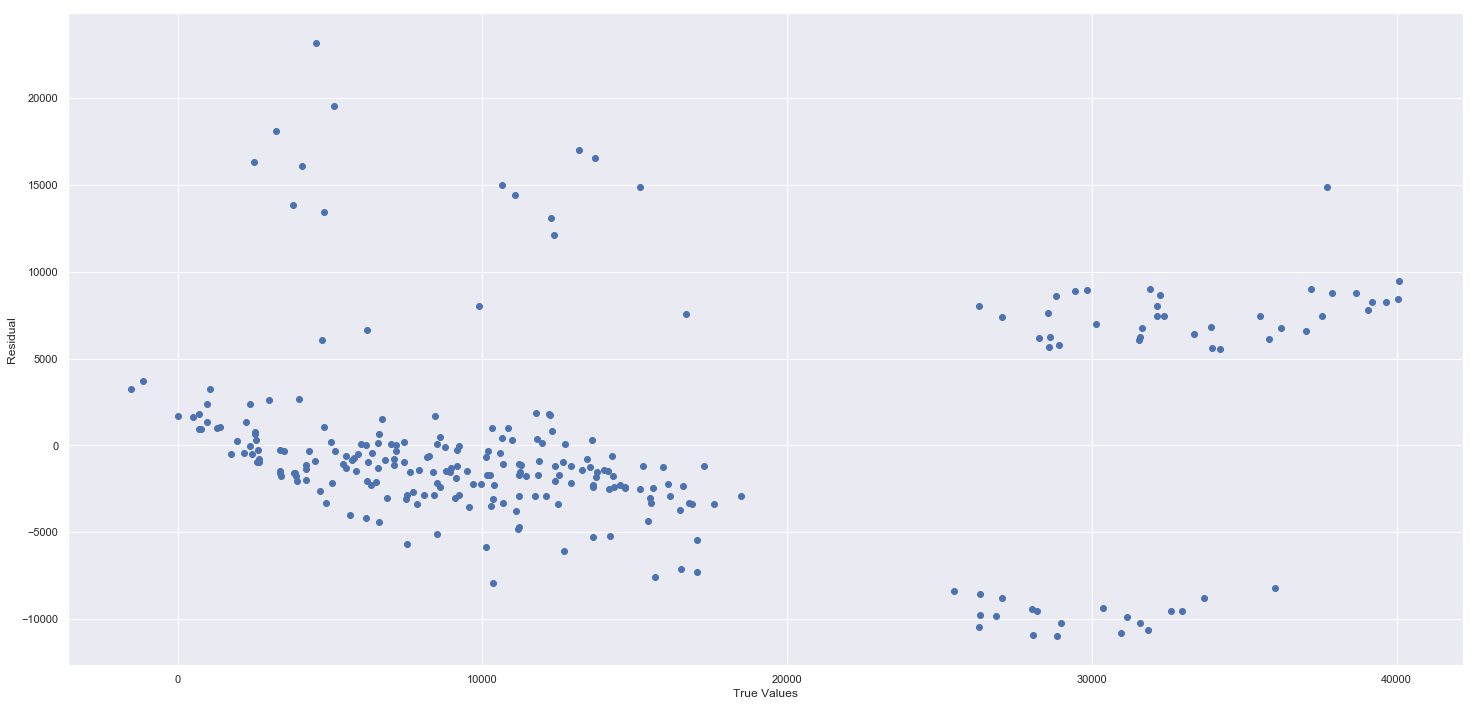

In [492]:
plt.scatter( df['prediction'], df['residual'] )
plt.xlabel( 'True Values' )
plt.ylabel( 'Residual' )

Text(0, 0.5, 'Residual')

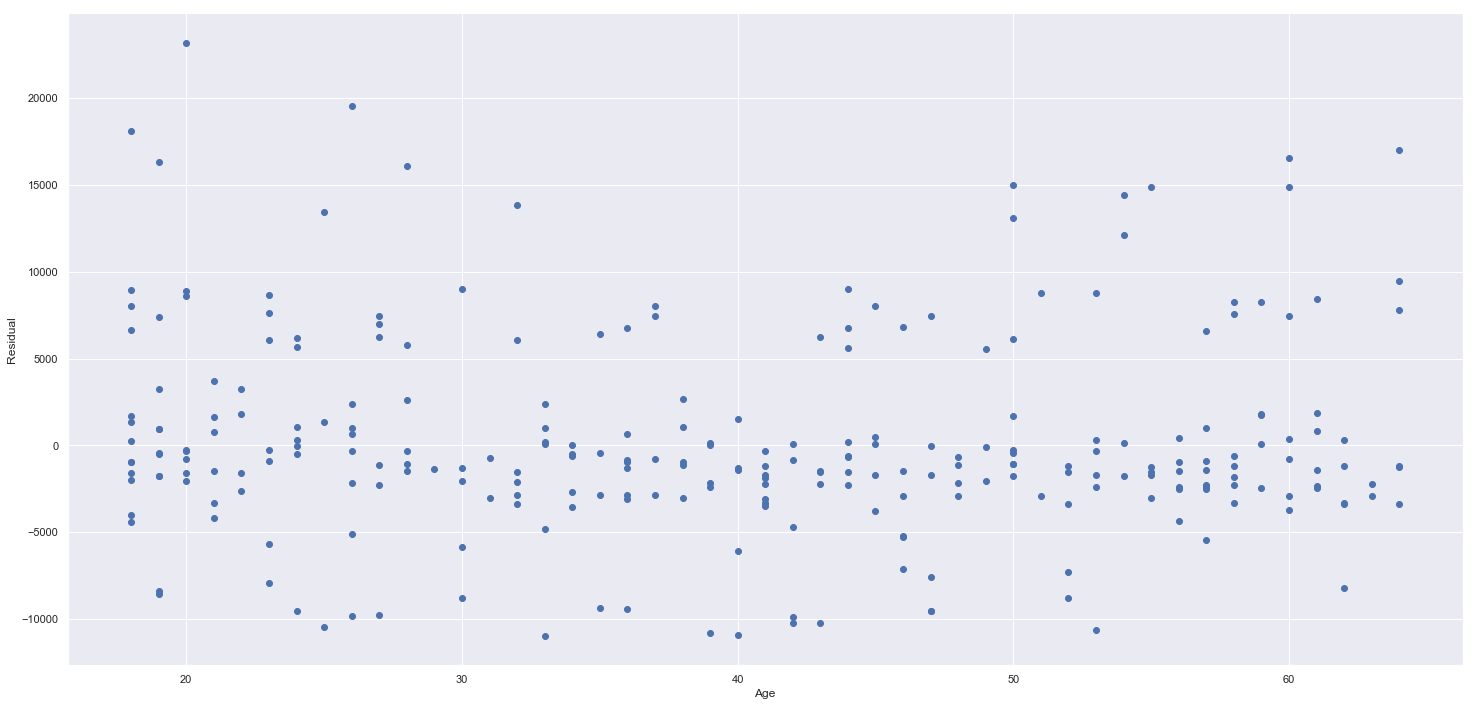

In [493]:
plt.scatter( df['age'], df['residual'] )
plt.xlabel( 'Age')
plt.ylabel( 'Residual' ) 

Text(0, 0.5, 'Residual')

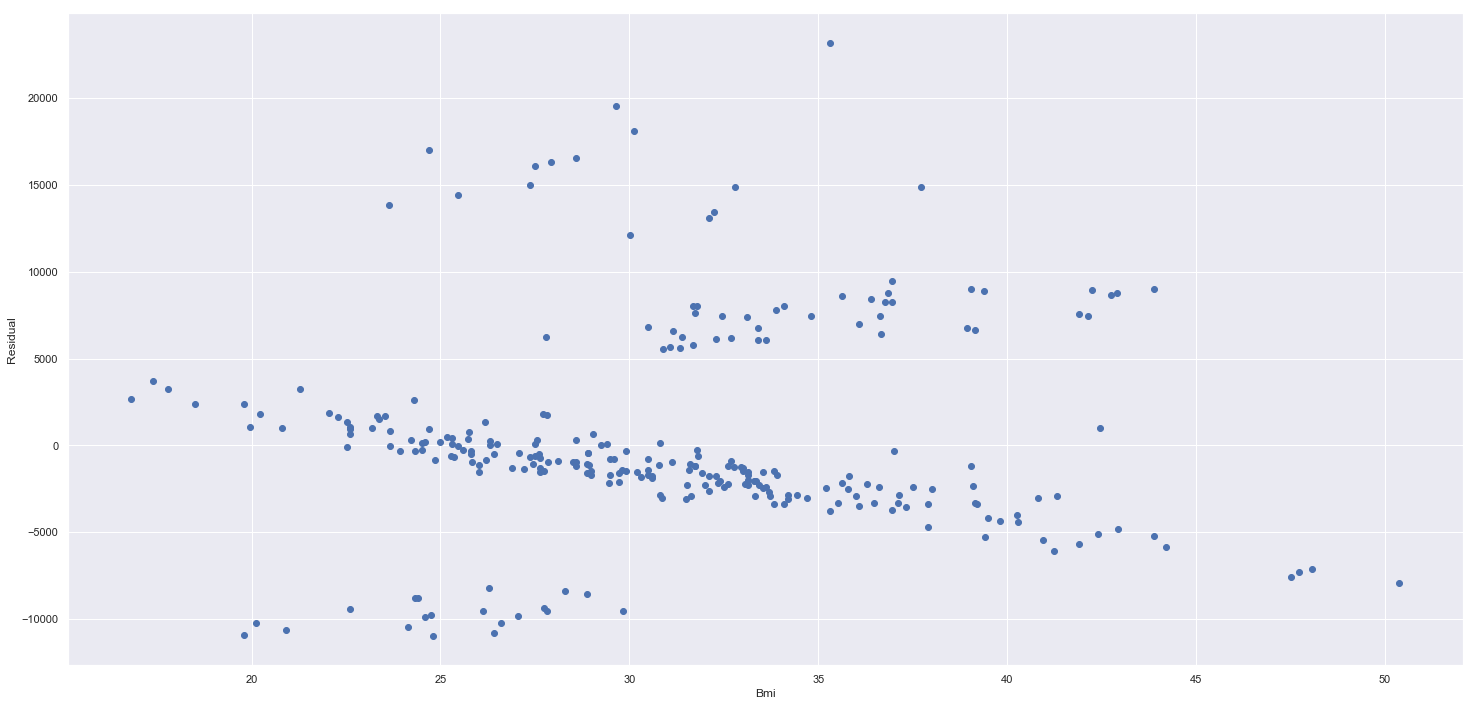

In [494]:
plt.scatter( df['bmi'], df['residual'] )
plt.xlabel( 'Bmi')
plt.ylabel( 'Residual' ) 

Text(0, 0.5, 'Residual')

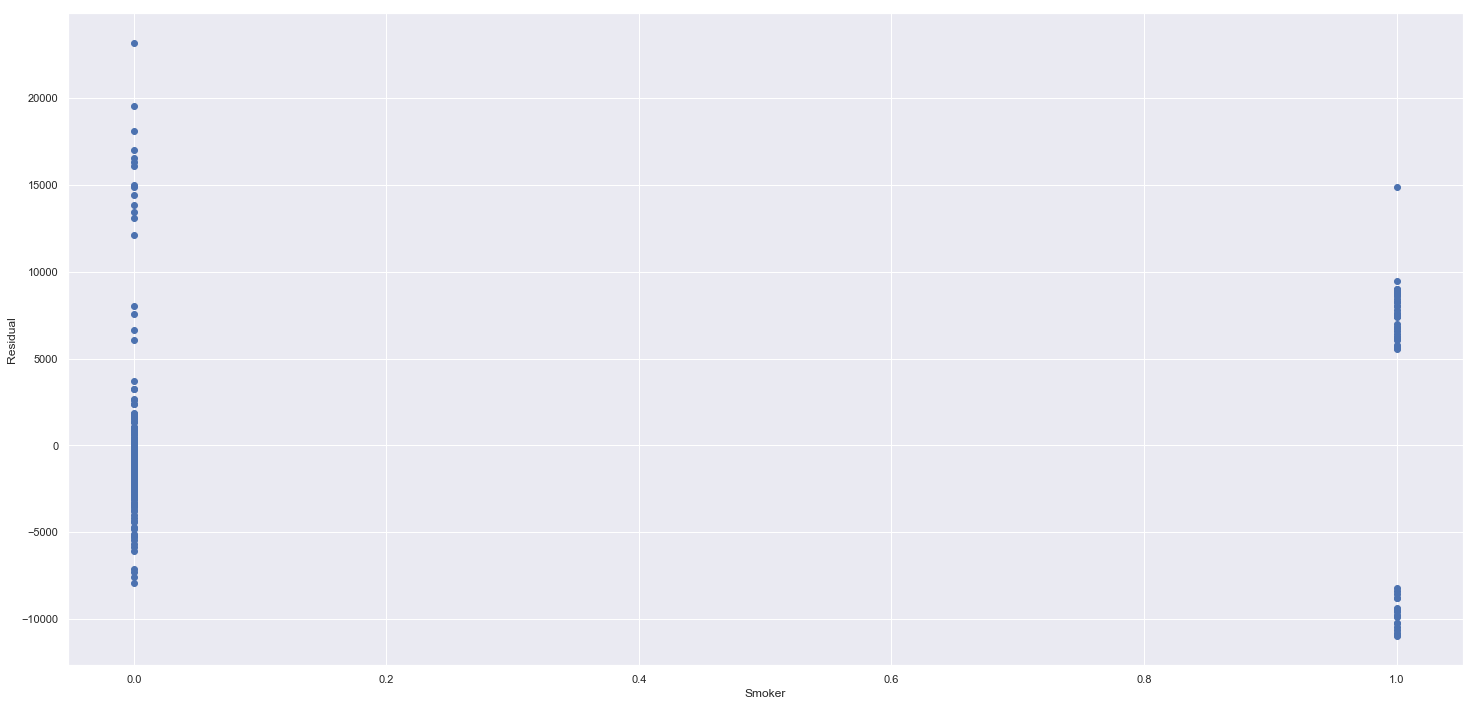

In [495]:
plt.scatter( df['smoker'], df['residual'] )
plt.xlabel( 'Smoker')
plt.ylabel( 'Residual' ) 